<a href="https://colab.research.google.com/github/ricardoestevez/datascience/blob/master/Tecnicas_Agrupamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Técnicas de Agrupamento

## *K-Means & K-Medoids*

### Resumo

Método K-Means, permite a clusterização dos dados via aprendizado de máquina não-supervisionado em K grupos a partir da sua proximidade quando não se possui uma categorização própria.

Ao definir um valor de K (_grupos_) o algoritmo irá selecionar centroides (_aleatoriamente_) e agrupar os dados de acordo com a distância (_euclidiana_) mais próxima do dado ao centroide. Após a primeira atribuição de centroides, um novo conjunto de centroides é calculado a partir da distância média dos dados de cada grupo e inicia-se mais uma vez a separação de grupos. Esses passos são repetidos até a convergência em que não tenha mais mudança significativa nos resultados.


Para a escolha do valor de *K* recomenda-se o método do 'Cotovelo', em que se gera o gráfico da soma dos erros quadráticos internos dos clusters dado o número de clusters, a partir de então observa-se em qual ponto o aumento de grupos passa a estabilizar a taxa de redução dos erros.

A diferença entre o método *K-Means* e *K-Medoids* é que ao passo que _K-Means_ seleciona um ponto aleatório no espaço _K-Medoids_ escolhe um dos valores existentes nos dados como ponto central.

### Vantagens e Desvantagens

*Vantagens*
- Possui processamento rápido, sem grande exigência computacional mesmo em grande quantidade de dados.
- Facil de implementar e boa escalabilidade.



*Desvantagens*
- Sensível a outliers, podendo deslocar muito a média.
- Precisa definir o valor de K préviamente.
- Se adequa melhor quando os cluestes possuem formato esférico.
- Pode convergir para mínimos locais

###Resumo prático

| Critério                     | K-means                         | K-medoids                          |
|-----------------------------|----------------------------------|------------------------------------|
| **Tipo de centróide**       | Média                            | Ponto real (medoide)               |
| **Robustez a outliers**     | Baixa                            | Alta                               |
| **Tipo de dados**           | Numéricos                        | Numéricos ou categóricos           |
| **Métrica**                 | Distância euclidiana (normalmente) | Qualquer métrica de distância     |
| **Escalabilidade**          | Alta                             | Baixa (menos eficiente)            |
| **Complexidade computacional** | O(nkt)                       | O(k(n−k)²) (ex.: PAM)              |
| **Interpretabilidade**      | Centróides fictícios             | Medoides reais                     |



### Exemplo Prático

Para o exemplo prático utilizei uma base de dados disponível no Kaggle, sobre segmentação de clientes. A mesma será utilizada em outros métodos de agrupamento para fins de comparação no final.

#### Leitura e Validação dos Dados

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import requests
import kagglehub

from google.colab import drive
drive.mount('/content/drive')

path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv(path + '/Mall_Customers.csv')
display(df.sample(5))

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
69,70,Female,32,48,47
96,97,Female,47,60,47
171,172,Male,28,87,75
51,52,Male,33,42,60
163,164,Female,31,81,93


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


A base de dados apresentada, possui 200 linhas com 5 colunas, com informações de ID usuário, Idade, Sexo, Renda Anual (k$) e Score de gasto (1-100). Além disso nenhuma das colunas possuem valores nulos.

In [5]:
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


#### Análise dos Dados

A distribuição etária entre Homens (88) e Mulheres (112), aparentam uma pequena diferença, com homens bem distribuidos entre todas as idades, enquanto mulheres aparentam se concentrar mais na faixa dos 20-50 anos. Contudo a idade média nos dois é próxima, Homens em 39,8 anos e mulheres em 38,1 anos.

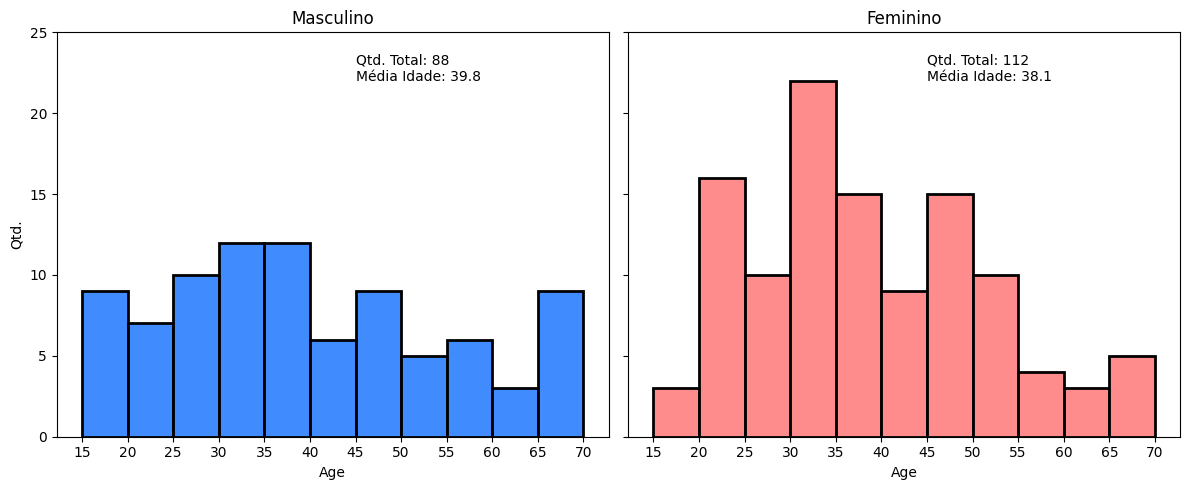

In [6]:
masc_df = df[df['Gender'] == 'Male']
fem_df = df[df['Gender'] == 'Female']
idade_range = range(15, 75, 5)


fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.histplot(masc_df['Age'], bins=idade_range, kde=False, color='#0066ff', ax=ax1, edgecolor="k", linewidth=2)
ax1.set_xticks(idade_range)
ax1.set_ylim(top=25)
ax1.set_title('Masculino')
ax1.set_ylabel('Qtd.')
ax1.text(45,23, "Qtd. Total: {}".format(masc_df["Age"].count()))
ax1.text(45,22, "Média Idade: {:.1f}".format(masc_df["Age"].mean()))

sns.histplot(fem_df['Age'], bins=idade_range, kde=False, color='#ff6666', ax=ax2, edgecolor="k", linewidth=2)
ax2.set_xticks(idade_range)
ax2.set_ylim(top=25)
ax2.set_title('Feminino')
ax2.set_ylabel('Qtd.')
ax2.text(45,23, "Qtd. Total: {}".format(fem_df["Age"].count()))
ax2.text(45,22, "Média Idade: {:.1f}".format(fem_df["Age"].mean()))

plt.tight_layout()
plt.show()

In [7]:
print('Teste de Kolgomorov-Smirnov, p-valor: {:.2f}'.format(stats.ks_2samp(masc_df["Age"], fem_df["Age"])[1]))

Teste de Kolgomorov-Smirnov, p-valor: 0.49


Apesar da diferença visual entre os grupos, utilizando o teste de Kolmogorov-Smirnov para verificar a diferença entre as distribuições, temos que os dois grupos não possuem diferença significante estatisticamente.

#### Aplicação K-Means

In [8]:
from sklearn.cluster import KMeans

In [9]:
# Somente dados númericos entram na clusterização

X_numeric = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

Utilizando a técnica do Cotovelo para definir o valor de K, onde o valor ótimo esperado ocorre no inicio da curva em $K = 5$.

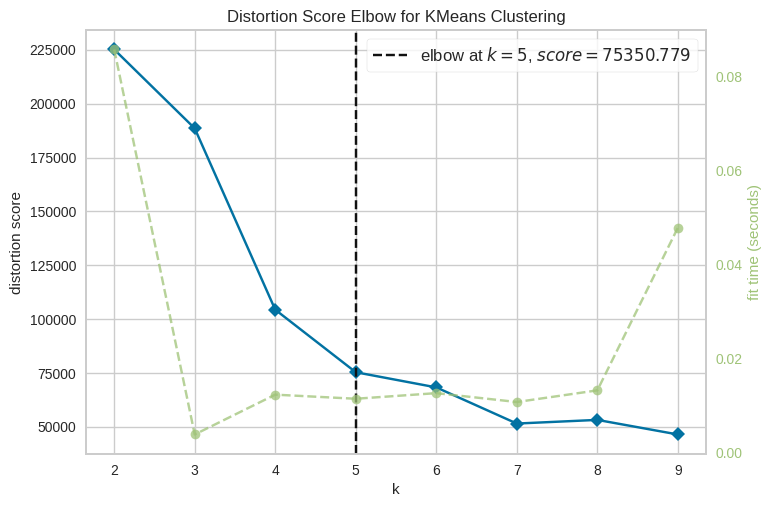

In [10]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numeric)
visualizer.show()
plt.show()

No pacote _sklearn_ existe uma função de inicialização chamada **'k-means++'** que pode ser passada no código, que cria centroides iniciais gerais distantes entre si, de modo a aumentar a probabilidade de se obter resultados melhores.

In [11]:
KM_group = KMeans(n_clusters = 5, random_state = 1, init= 'k-means++').fit(X_numeric)

df_clustered = X_numeric.copy()
df_clustered.loc[:,'Cluster'] = KM_group.labels_


In [12]:
df_clustered.head()

,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,19,15,39,4
1,21,15,81,2
2,20,16,6,4
3,23,16,77,2
4,31,17,40,4


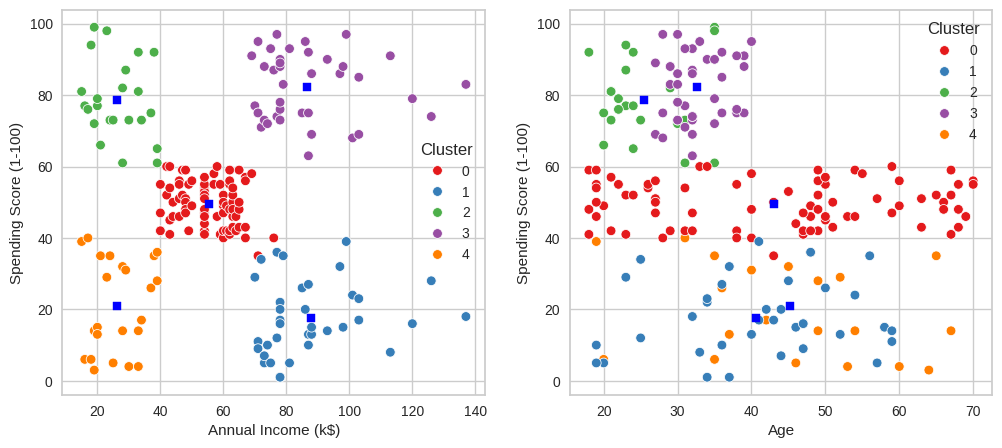

In [13]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))

scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=df_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_group.cluster_centers_[:,1],KM_group.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_group.cluster_centers_[:,0],KM_group.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

Pelo gráfico da esquerda com a relação entre Salário anual e score de gastos, é possível observar 5 grupos bem definidos de pessoas.

0. Renda média e gasto médio
1. Alta renda e baixo gasto
2. Baixa Renda e alto gasto
3. Alta renda e alto gasto
4. Baixa Renda e baixo gasto

Enquanto isso, o gráfico de score de gastos vs idade não apresenta uma separação tão bem definida.

